In [2]:
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt

In [22]:
path = os.getcwd()
print(path)
l= 50
sub_samp = 25
scales = np.arange(1,33)
wavelet = 'morl'
vmin =1
vmax = 0
df = pd.read_csv("power_10Hz.csv", delimiter = ",",encoding = 'unicode_escape').drop(columns = 'Unnamed: 0')
#diff_df = df.diff().drop(index = 0).reset_index().drop(columns = 'index')
n = int(len(df)/l)  

/home/user/Desktop/jupyter1/DDP


In [23]:
diff_df = df.diff().drop(index = 0).reset_index().drop(columns = 'index')

In [ ]:
indices = [1100500,1108000,1234000,1234500,2564500,2569000,3243000,3244500,3246250, 3263500,3268500,3269750,3481750]

In [ ]:
indices_l = [int(x/(l*sub_samp)) for x in indices]

In [ ]:
l

In [ ]:
for i in tqdm(range(1,n+1)):
#for i in tqdm(indices_l):
    dff = diff_df[l*(i-1): l*i]
    
    data_in_use = np.array(dff) 
    data_in_use[np.abs(data_in_use) < 0.001] = 0
    if data_in_use.max() == 0.0 or data_in_use.min() == 0.0:
      continue
    coef, freqs=pywt.cwt(data_in_use,scales,wavelet = wavelet)
    mod_coeff = np.abs(coef)
    file_path = "/home/user/Desktop/jupyter1/DDP/Scalograms/" + str(i) + '_sc.png'
    if np.amin(mod_coeff) < vmin:
      vmin = np.amin(mod_coeff)
    else:
      pass
    if np.amax(mod_coeff) > vmax:
      vmax = np.amax(mod_coeff)
    else:
      pass
  
    plt.figure(figsize = (32,32))
    plt.imshow(np.abs(coef), origin = 'lower', cmap = 'BrBG', aspect = 'auto',
          vmin = vmin, vmax = vmax)
    plt.title('Scalogram_' + str(i))
    plt.ylabel('Scale')
    plt.xlabel('Time')
    plt.savefig(file_path)
    plt.tight_layout()
    plt.close()

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2023-06-16 19:49:18.804637: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 19:49:19.645856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1 Physical GPUs, 1 Logical GPUs


2023-06-16 19:49:20.814538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-16 19:49:20.902680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-16 19:49:20.902807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.preprocessing import image
import keras.utils as image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd
#!pip install Pillow
import sklearn
import os, glob
import matplotlib.pyplot as plt

import pywt
#!pip install keras
import keras
#!pip install seaborn
import seaborn as sns
from sklearn.manifold import TSNE
from PIL import Image

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [ ]:
# %load anomaly_scalograms.py
"""anomaly_scalograms.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1r2OKY61ClOP-vmIErPdLy-aeZcpnYiV7
"""
path = os.getcwd()
print(path)
window_time = 50
slide_time = 5
sub_samp = 25 #freq = 250/sub_samp
l= int(window_time*250/sub_samp) #
slide = int(slide_time*250/sub_samp)

scales = np.arange(1,33)
wavelet = 'morl'
vmin =1
vmax = 0
df = pd.read_csv("power_10Hz.csv", delimiter = ",",encoding = 'unicode_escape').drop(columns = 'Unnamed: 0')
#diff_df = df.diff().drop(index = 0).reset_index().drop(columns = 'index')
n = int((len(df)-l)/(slide)) +1

diff_df = df.diff().drop(index = 0).reset_index().drop(columns = 'index')  # differenced power signal data. Anomalies in these scalograms are more pronounced than the ones with the original signal

#THIS is to generate scalograms

for i in tqdm(range(1,n+1)):
    dff = diff_df[slide*(i-1): l+(slide*(i-1))]
    data_in_use = np.array(dff) 
    data_in_use[np.abs(data_in_use) < 0.001] = 0
    
    #if data_in_use.max() == 0.0 or data_in_use.min() == 0.0:
     # continue
    coef, freqs=pywt.cwt(data_in_use,scales,wavelet = wavelet)
    mod_coeff = np.abs(coef)
    file_path = '/home/user/Desktop/jupyter1/DDP/Scalograms10Hz_Sliding_50_5/' + str(i) + '_sc.png'
    if np.amin(mod_coeff) < vmin:
      vmin = np.amin(mod_coeff)
    else:
      pass
    if np.amax(mod_coeff) > vmax:
      vmax = np.amax(mod_coeff)
    else:
      pass
  
    plt.figure(figsize = (20,20))
    plt.imshow(np.abs(coef), origin = 'lower', cmap = 'coolwarm', aspect = 'auto',
          vmin = vmin, vmax = vmax)
    plt.title('Scalogram_' + str(i))
    plt.ylabel('Scale')
    plt.xlabel('Time')
    plt.savefig(file_path)
    plt.tight_layout()
    plt.close()

#Anomalies on a partial signal: scalograms to look at are the ones with numbers 4396, 4403, 4440, 4938-45, 4972-76, 10277, 10279, 12974-988

# This is to extract features using Resnet50. Pick the output at the last but one layer of the network
from pandas.core.arrays import numeric
import re
df_for_feature_vectors = pd.DataFrame(columns = None)
model = ResNet50(weights = 'imagenet', include_top = False, pooling = 'avg')
file_path = '/home/user/Desktop/jupyter1/DDP/Scalograms10Hz_Sliding_50_5/'
df_for_feature_vectors = pd.DataFrame()
#error_indices = list()
for infile in tqdm(glob.glob(file_path + '*.png')):
  fileindex = re.findall('[0-9]+', infile)
  fileindex = [int(i) for i in fileindex][1]
  img = image.load_img(infile)
  img = img.resize((1600,1600))  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis =0)
  x = preprocess_input(x)
#   try:
  features = model.predict(x)[0]
  features_arr = np.char.mod('%f', features)
  df_for_feature_vectors = pd.concat((df_for_feature_vectors, pd.Series(features_arr).rename('FeatureVector_' +str(fileindex))),axis = 1)
  #df_for_feature_vectors['FeatureVector_' +str(fileindex)]= features_arr
#   except:
#     error_indices.append(fileindex)
#     continue
    

'''
  if k != n:
    if k % 1000 == 0: 
      print("files_completed " + str(k))
      df_for_feature_vectors.to_csv("Power_difference_features" + str(k) + ".csv")
  else:
    df_for_feature_vectors.to_csv("Power_difference_features_All.csv")
'''
df_for_feature_vectors.to_csv("/home/user/Desktop/jupyter1/DDP/Scalograms10Hz_Sliding_50_5/Power_difference_features_All.csv")


/home/user/Desktop/jupyter1/DDP


  7%|██▍                                 | 2107/31355 [12:53<2:52:49,  2.82it/s]

In [ ]:

df_SC_features = pd.read_csv('/home/user/Desktop/jupyter1/DDP/Scalograms10Hz_Sliding_50_5/Power_difference_features_All.csv')
df_SC_features = df_SC_features.loc[:,~df_SC_features.T.duplicated(keep='first')]
df_SC_features = df_SC_features.drop(df_SC_features.columns[0], axis=1)

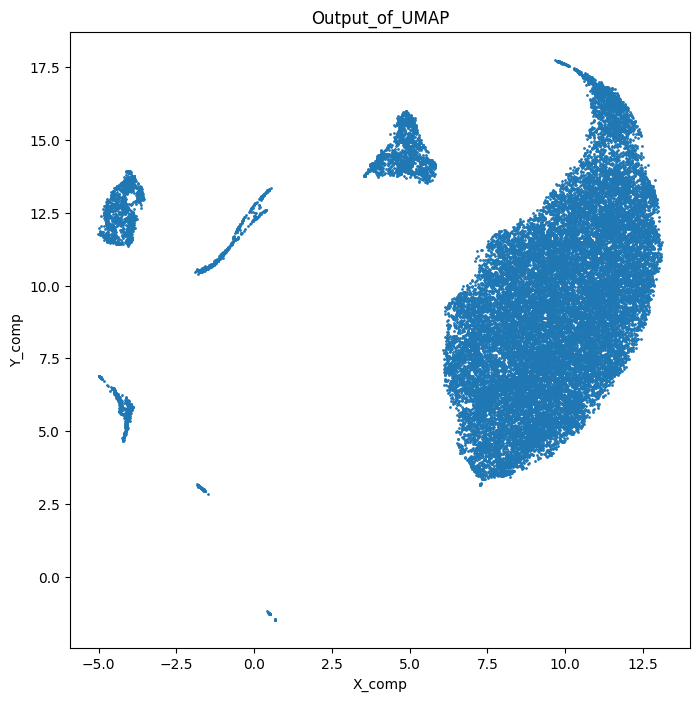

In [20]:


# This is to create UMAP visualization over the features and see clusters
# See if any of the above anomalies stand out in the UMAP. (Observation: Not easily discernible. Perhaps we are losing information due to the transformation". Need to observe a stretch of scalograms and infe
#!pip install umap-learn              
import umap
import umap.umap_ as umap
#np.random.seed(444)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
X_embedded_umap = reducer.fit_transform(df_SC_features.values.transpose())
plt.figure(figsize = (8,8))
plt.scatter(X_embedded_umap[:,0],X_embedded_umap[:,1], s= 1)
plt.title("Output_of_UMAP")
plt.xlabel('X_comp')
plt.ylabel('Y_comp')
plt.show()

In [6]:
X_embedded_umap[:,0]

(30809,)